This is an example notebook to demonstrate the prediction of temperature time-series data using the generalized Langevin equation (GLE) on the example of a loaded Berlin weather trajectory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mempred import *

%matplotlib inline

/home/hendrykn123/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/hendrykn123/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:64: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


### Loading weather data

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,moonset,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2009-02-10,5,-1,0.0,4.9,1,1,89,07:42 PM,08:42 AM,...,-2,26,87,91,1.1,991,5,9,162,16
1,2009-02-11,3,0,0.2,4.9,1,1,82,09:07 PM,08:56 AM,...,-5,36,99,92,1.1,1001,3,8,298,23
2,2009-02-12,0,-3,0.0,4.9,1,1,74,10:29 PM,09:09 AM,...,-6,24,89,89,0.0,1012,0,10,293,15
3,2009-02-13,1,-4,0.0,9.9,2,2,67,11:49 PM,09:22 AM,...,-5,14,21,88,0.0,1016,1,9,266,10
4,2009-02-14,0,-5,0.2,6.6,1,1,59,No moonrise,09:36 AM,...,-7,20,65,93,0.2,1021,0,6,317,13


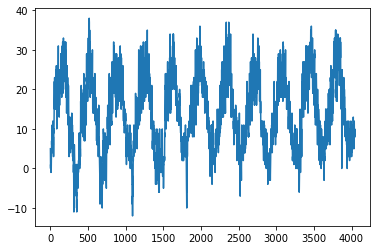

In [2]:
data = pd.read_csv('berlin.csv')
data.head()
data['maxtempC'].plot()

data.head()

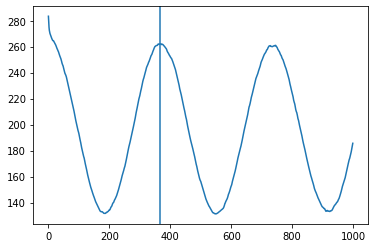

In [3]:
#plotting positions correlation
plt.plot(correlation(data["maxtempC"])[:1000])
plt.axvline(x=365)

### Filtering Method (For Trend and Seasonalities)
Since we know that the oscillation has to be included in the memory kernel, we split the trajectory into an oscillation , a trend and the residual part.

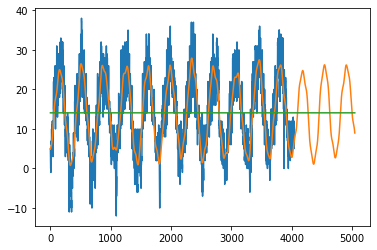

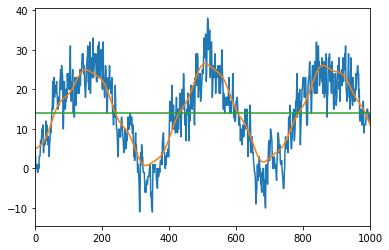

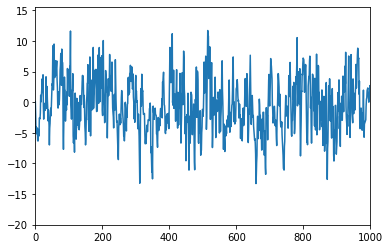

In [4]:
t= data.index.values
x = data['maxtempC'].values.astype(float)
n_steps = 1000 #extrapolate into future
cut = int(len(x))
#mph = 0.01
#N=20
#deg_polyfit = 0#1 #trend captured by long sine fit, and not linear fit 
#param,x_res, x_trend = extrapolate_fourier_analysis_trend(t,x,cut,n_steps,find_peaks=False,mph=mph,N=1,verbose=False,fit=True)
#param,x_seas, x_noise,_ = extrapolate_fourier_analysis(t,x_res,cut,n_steps,deg_polyfit,mph,N,verbose=True,fit=True,lp_trend=False)
#x_seas+=x_trend

detrend = True
fit_trend_part = True
N_trend=1
deseasonalize = True
N_seas=5
fit_seas_part = False

x_noise,x_seas,x_trend = filter_and_extrapolate_time_series(t,x,cut,n_steps,verbose=False,detrend=detrend,fit_trend_part=fit_trend_part,
                                                               N_trend=N_trend,deseasonalize=deseasonalize,N_seas=N_seas,fit_seas_part=fit_seas_part)

t_noise = np.arange(len(x_noise))
plt.plot(data['maxtempC'])
plt.plot(x_seas)
plt.plot(x_trend)
plt.show()

plt.plot(data['maxtempC'])
plt.plot(x_seas)
plt.plot(x_trend)
plt.xlim(0,1000)
plt.show()

plt.plot(x_noise)
plt.xlim(0,1000)
plt.show()
plt.show()

### Memory Kernel Extraction (with Filtering and Mitterwallner Method)

dt = 1.0


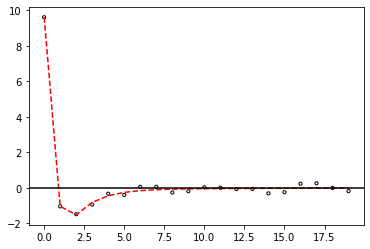

plotting extracted memory kernel...


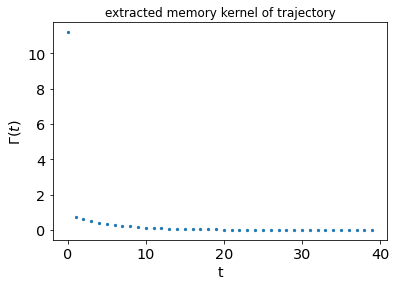

plotting running integral of kernel...


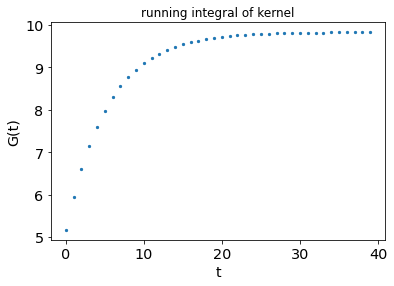

fitting parameters memory kernel
[ 0.86207914  5.16819627  5.41124288  1.88623842 35.53779617]


In [5]:
t= data.index.values
x = data['maxtempC'].values.astype(float)
n_steps = 1000 #extrapolate into future
cut = int(len(x))

#mph = 0.01
#N=20
#deg_polyfit = 0#1 #trend captured by long sine fit, and not linear fit 
#param,x_res, x_trend = extrapolate_fourier_analysis_trend(t,x,cut,n_steps,find_peaks=False,mph=mph,N=1,verbose=False,fit=True)
#param,x_seas, x_noise,_ = extrapolate_fourier_analysis(t,x_res,cut,n_steps,deg_polyfit,mph,N,verbose=False,fit=True,lp_trend=False)
#x_seas+=x_trend

detrend = True
fit_trend_part = True
N_trend=1
deseasonalize = True
N_seas=5
fit_seas_part = False
x_noise,x_seas,x_trend = filter_and_extrapolate_time_series(t,x,cut,n_steps,verbose=False,detrend=detrend,fit_trend_part=fit_trend_part,
                                                               N_trend=N_trend,deseasonalize=deseasonalize,N_seas=N_seas,fit_seas_part=fit_seas_part)


p0=[0.21,  1.82, 5.88,0.23, 9.276517012388659]
bounds = [[-10,0,0,0,0],[10,10,10,10,100]]

predict=GLEPrediction(bins=100,  cut = cut ,trunc=40, dt = 1, no_fe=False, plot_pred = False,kde_mode=True,mori=True,disc=0,hs_pred=False)
kernel = predict.extractKernel_estimator([x_noise], plot_kernel =True,p0=p0,bounds=bounds,end=20,verbose=True)

print("fitting parameters memory kernel")
print(kernel[-1])

### Performing prediction by extracting memory kernel and simulate GLE
 We predict the residual part and add it to the extrapolated oscillation.

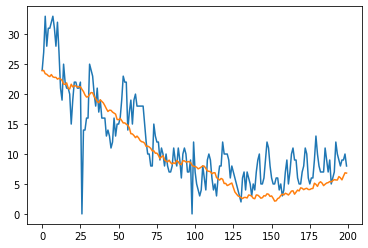

In [6]:
t= data.index.values
x = data['maxtempC'].values.astype(float)
n_steps = 200 #extrapolate into future
cut = int(len(x))-n_steps

#mph = 0.01
#N=20
#deg_polyfit = 0#1 #trend captured by long sine fit, and not linear fit 
#param,x_res, x_trend = extrapolate_fourier_analysis_trend(t,x,cut,n_steps,find_peaks=False,mph=mph,N=1,verbose=False,fit=True)
#param,x_seas, x_noise,_ = extrapolate_fourier_analysis(t,x_res,cut,n_steps,deg_polyfit,mph,N,verbose=False,fit=True,lp_trend=False)
#x_seas+=x_trend

detrend = True
fit_trend_part = True
N_trend=1
deseasonalize = True
N_seas=5
fit_seas_part = False
x_noise,x_seas,x_trend = filter_and_extrapolate_time_series(t,x,cut,n_steps,verbose=False,detrend=detrend,fit_trend_part=fit_trend_part,
                                                                N_trend=N_trend,deseasonalize=deseasonalize,N_seas=N_seas,fit_seas_part=fit_seas_part)


correct_fr_hist=True
params_correct=[0.2,10]
p0=[0.21,  1.82, 5.88,0.23, 9.276517012388659]
bounds = [[-10,0,0,0,0],[10,10,10,10,10]]

predict=GLEPrediction(bins=100,  cut = cut ,trunc=40, dt = 1, no_fe=False, plot_pred = False,kde_mode=True,mori=True,disc=0,hs_pred=False)
kernel = predict.extractKernel_estimator([x_noise], plot_kernel =False,p0=p0,bounds=bounds,end=20,verbose=False)
GLE1=predict.predictGLE([x_noise], n_steps=n_steps, n_preds = 100, return_full_trjs=True, zero_noise = False,cond_noise = 1,correct_fr_hist=correct_fr_hist,params_correct=params_correct)

pred_GLE1 = GLE1[2] + x_seas[cut:]

plt.plot(data["maxtempC"][cut:cut+n_steps].values)
plt.plot(pred_GLE1)
